In [2]:
# Import external tools:
import time 
from matplotlib import pyplot as plt
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torchaudio
import soundfile as sf
from scipy import signal
import getpass
import pandas as pd
import numpy as np
import sys
import os
import importlib
from scipy.io import wavfile
from IPython.display import Audio
from datetime import datetime
from sklearn.manifold import TSNE

# I am running this script on two different computers, so i need to change paths
# depending on computer in use: 
if getpass.getuser()=="joanna.luberadzka":
    projectdir="/Users/joanna.luberadzka/Documents/VAE-IR/"
    datadir="/Users/joanna.luberadzka/Documents/Data/IR_Arni_upload_numClosed_0-5/"
elif getpass.getuser()=="ubuntu":
    projectdir="/home/ubuntu/joanna/VAE-IR/"
    datadir="/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5/"

# Add path of this project
sys.path.insert(0, projectdir+'src/')

# Import and automatically reload my own modules:
import models; importlib.reload(models)
import train; importlib.reload(train)
import datasetprep as dsprep; importlib.reload(dsprep)
import helpers; importlib.reload(helpers)

<module 'helpers' from '/home/ubuntu/joanna/VAE-IR/src/helpers.py'>

filename= /home/ubuntu/Data/IR_Arni_upload_numClosed_0-5/IR_numClosed_0_numComb_1_mic_1_sweep_3.wav
rt= 1.87027210884354
drr= -3.24458776629423


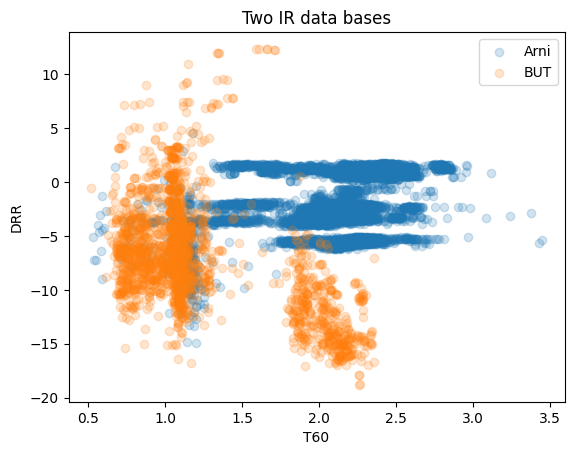

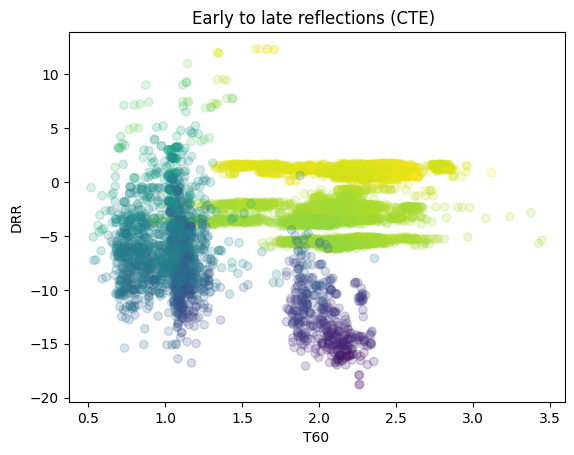

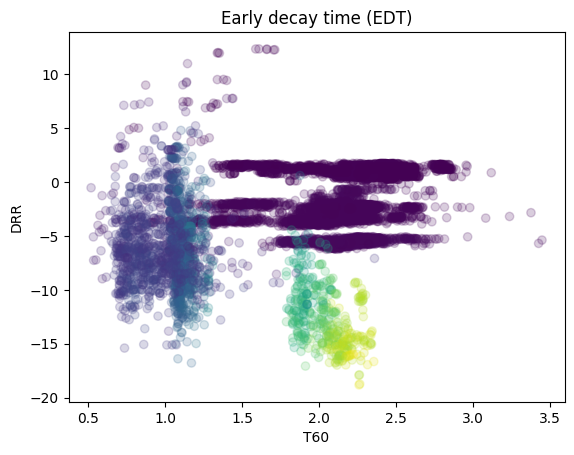

In [3]:
# Using matlab, I created a table summarizing two IR data bases (Arni and BUT)
# Table contains file path, and acoustic parameters: rt,drr,cte,edt

# -- Data: --
if getpass.getuser()=="joanna.luberadzka":
    INFO_FILE = projectdir + "irstats_ARNIandBUT_local.csv"
elif getpass.getuser()=="ubuntu":
    INFO_FILE = projectdir+"irstats_ARNIandBUT_datura.csv"

IrData = pd.read_csv(INFO_FILE,delimiter=',')
IrData.head()

# get info of an impulse response with a specific index
print("filename= "+ IrData["filepath"][2])
print("rt= "+ str(IrData["rt"][2]))
print("drr= "+ str(IrData["drr"][2]))

# plot parameters of impulse responses in the data  
fig, ax = plt.subplots()
ax.scatter(x=IrData["rt"][0:11331], y=IrData["drr"][0:11331],label="Arni", alpha=0.2)
ax.scatter(x=IrData["rt"][11331:], y=IrData["drr"][11331:],label="BUT",alpha=0.2)
plt.xlabel("T60")
plt.ylabel("DRR")
plt.legend()
ax.set(title="Two IR data bases")
plt.show()

fig, ax = plt.subplots()
ax.scatter(x=IrData["rt"], y=IrData["drr"],c=IrData["cte"], alpha=0.2)
sc1=plt.xlabel("T60")
sc2=plt.ylabel("DRR")
ax.set(title="Early to late reflections (CTE) ")
plt.show()

fig, ax = plt.subplots()
ax.scatter(x=IrData["rt"], y=IrData["drr"],c=IrData["edt"], alpha=0.2)
plt.xlabel("T60")
plt.ylabel("DRR")
ax.set(title="Early decay time (EDT)")
plt.show()


In [4]:
# get info of an impulse response with a specific index
filename= IrData["filepath"][1200]
# load chosen RIR
h, sr_h= torchaudio.load(filename)
# load anechoic sound file
x, sr_x=torchaudio.load("anechoic.wav")
# resample anechoic signal
x=torchaudio.transforms.Resample(sr_x,sr_h)(x)
# convolve anechoic signal with RIR: y=x*h
y = signal.fftconvolve(x, h, mode = 'full')
# set signal levels
x=x.numpy()
x=helpers.set_level(x,-30)
y=helpers.set_level(y,-30)
# save signals
sf.write("convolved.wav", y.T, sr_h, subtype='PCM_24')
sf.write("anechoic.wav", x.T, sr_h, subtype='PCM_24')

In [5]:
Audio('convolved.wav')

In [6]:
Audio('anechoic.wav')

In [7]:
# Plot anechoic signal, convolved signal and impulse response

# plt.figure(1)
# plt.plot(x.T,label='anechoic')
# plt.plot(y.T,label='convolved')
# plt.legend()
# plt.show()

# plt.figure(1)
# plt.plot(h.T,label='RIR')
# plt.legend()
# plt.show()

In [8]:
# ------------- TRAINING VARIATIONAL AUTOENCODER -------------

DEVICE=torch.device("cuda" if torch.cuda.is_available() else "mps")

# -- Data: --
if getpass.getuser()=="joanna.luberadzka":
    INFO_FILE = projectdir + "irstats_ARNIandBUT_datura.csv"
elif getpass.getuser()=="ubuntu":
    INFO_FILE = projectdir+"irstats_ARNIandBUT_datura.csv"

# Create dataset object
SAMPLING_RATE=8e3
dataset = dsprep.DatasetRirs(INFO_FILE,SAMPLING_RATE)

# split dataset into training set, test set and validation set
N_train = round(len(dataset) * 0.8)
N_rest = len(dataset) - N_train
trainset, restset = random_split(dataset, [N_train, N_rest])
N_test = round(len(restset) * 0.5)
N_val = len(restset) - N_test
testset, valset = random_split(restset, [N_test, N_val])

# create dataloaders
BATCH_SIZE=64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6,pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6,pin_memory=True)

# -- Model: --
#model=models.VAE_Lin(x_len=24000).to(DEVICE)
model = models.Conv1D_VAE(24000, 24)

# -- Training: --
LEARNRATE=1e-3
N_EPOCHS=100
trainparams={
"num_epochs": N_EPOCHS, 
"device": DEVICE,
"learnrate":LEARNRATE,
"optimizer": torch.optim.Adam(model.parameters(), LEARNRATE),
"criterion": nn.MSELoss()}

# training
start = time.time()
outputs_evol, loss_evol=train.training(model, trainloader, valloader, trainparams, 1)
end=time.time()
now=datetime.now(); dt_string = now.strftime("%d-%m-%Y--%H-%M")
print(f"training time: {(end-start)/N_EPOCHS}" ) 
torch.save(model.state_dict(), projectdir + "models/trained_model_"+dt_string+".pth")

AttributeError: module 'models' has no attribute 'Conv1D_VAE'

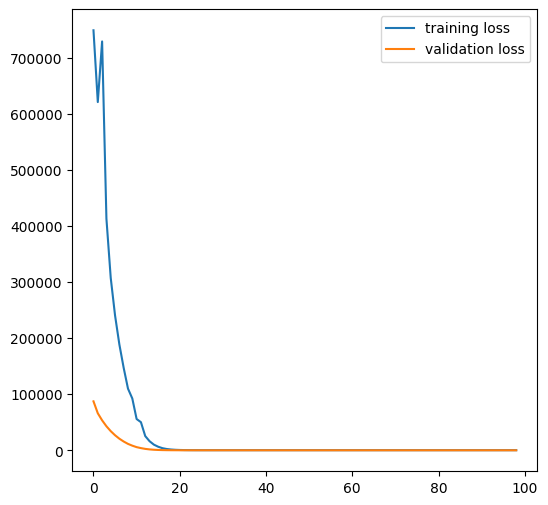

In [9]:
loss_evol_unziped=list(zip(*loss_evol))
plt.figure(figsize=(6, 6))
train_loss=loss_evol_unziped[0][1:]
val_loss=loss_evol_unziped[1][1:]
plt.plot(train_loss,label="training loss")
plt.plot(val_loss,label="validation loss")
plt.legend()

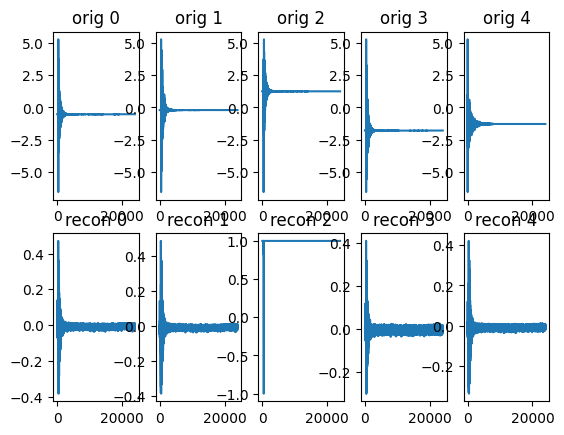

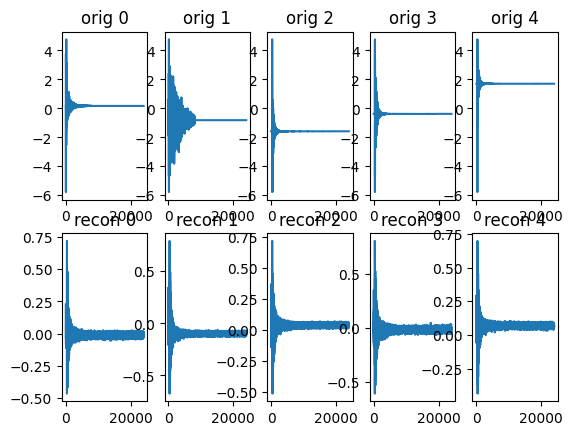

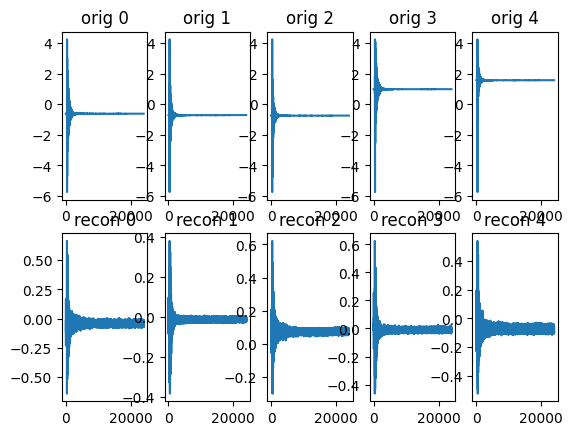

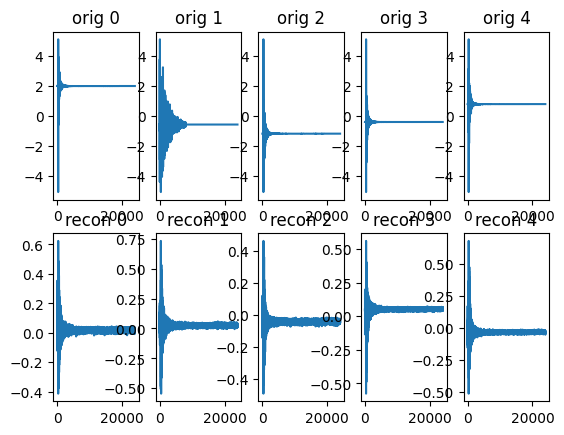

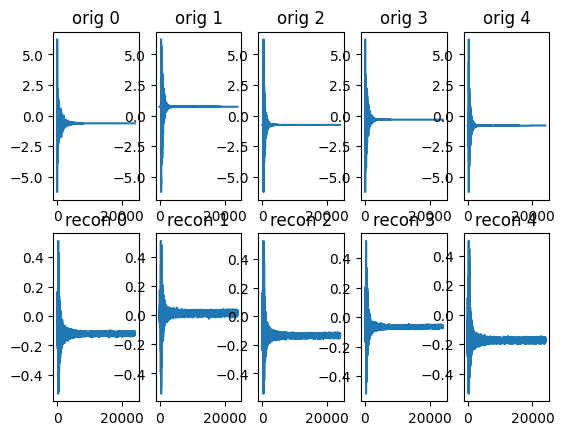

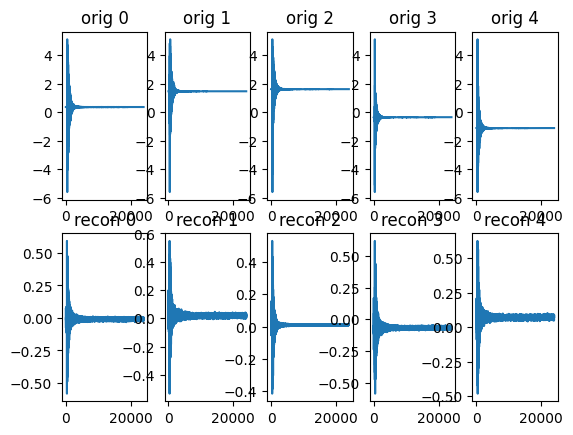

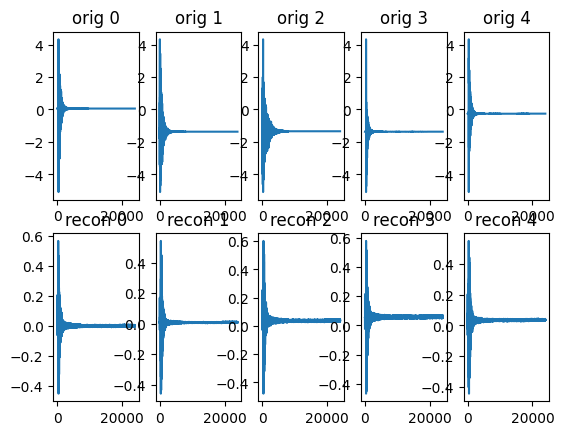

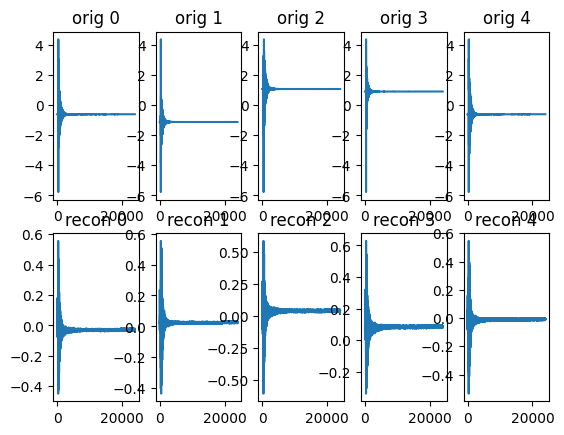

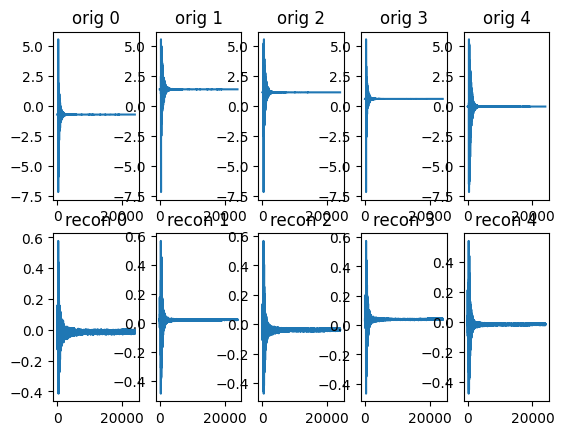

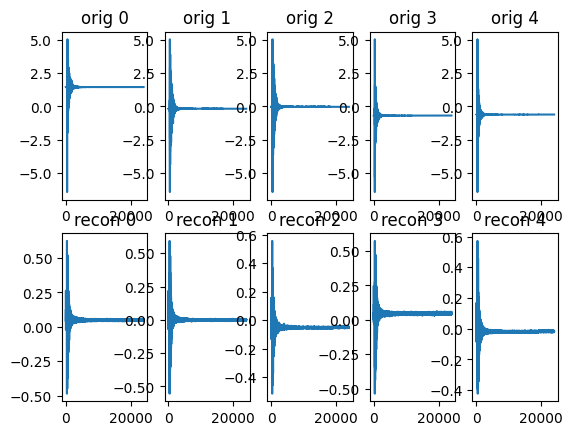

In [10]:
# test = print the reconstruction
n_examples=5
for i in range(0,100,10):
    fig, axs = plt.subplots(2,n_examples)
    x_orig=outputs_evol[i][1]
    x_recon=outputs_evol[i][2]
    x_label=outputs_evol[i][3]
    for k in range(0,n_examples):
        x_orig_plot=torch.squeeze(x_orig[k].detach()).cpu()
        x_recon_plot=torch.squeeze(x_recon[k].detach()).cpu()
        x_label_plot=str(k)
        

        axs[0,k].set_title("orig "+ str(x_label_plot))
        axs[0,k].plot(x_orig_plot)
        
        axs[1,k].set_title("recon "+ str(x_label_plot))
        axs[1,k].plot(x_recon_plot)

        
    plt.show(block=False)